## Data
The data is a set of images chosen at various locations chosen at random in the subsurface. The images are 101 x 101 pixels and each pixel is classified as either salt or sediment. In addition to the seismic images, the depth of the imaged location is provided for each image. The goal of the competition is to segment regions that contain salt.

## Acknowledgement
https://www.kaggle.com/competitions/tgs-salt-identification-challenge/data

In [1]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

seed=24
batch_size=100

def Generator(img_path,mask_path):
    
    frame_args=dict(rescale=1./255,
                    horizontal_flip=True,
                    vertical_flip=True)
    mask_args=dict(rescale=1./255,
                   horizontal_flip=True,
                   vertical_flip=True)
    frame_datagen = ImageDataGenerator(**frame_args)
    mask_datagen = ImageDataGenerator(**mask_args)
    
    frame_generator = frame_datagen.flow_from_directory(
        img_path,
        class_mode = None,
        color_mode = 'rgb',
        target_size = (96,128),
        batch_size = batch_size,
        seed=seed)
    mask_generator = mask_datagen.flow_from_directory(
        mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        target_size = (96,128),
        batch_size = batch_size,
        seed=seed)
    
    train_generator=zip(frame_generator,mask_generator)
    
    for (frame,mask) in train_generator:
        yield (frame,mask)

In [2]:
val_img_path='./Data/Test/Images/'
val_mask_path='./Data/Test/Masks/'

val_img_gen=Generator(val_img_path,val_mask_path)

In [3]:
from models import Unet,ResUnet
from keras.models import load_model
import random
import numpy as np

model_unet = load_model("./unet.hdf5", compile=False)
model_resunet = load_model("./Resunet.hdf5", compile=False)
model_AttentionResunet = load_model("./AttentionResunet.hdf5", compile=False)

x,y = val_img_gen.__next__()

Found 400 images belonging to 1 classes.
Found 400 images belonging to 1 classes.


Text(0.5, 1.0, 'AttentionResunet Prediction')

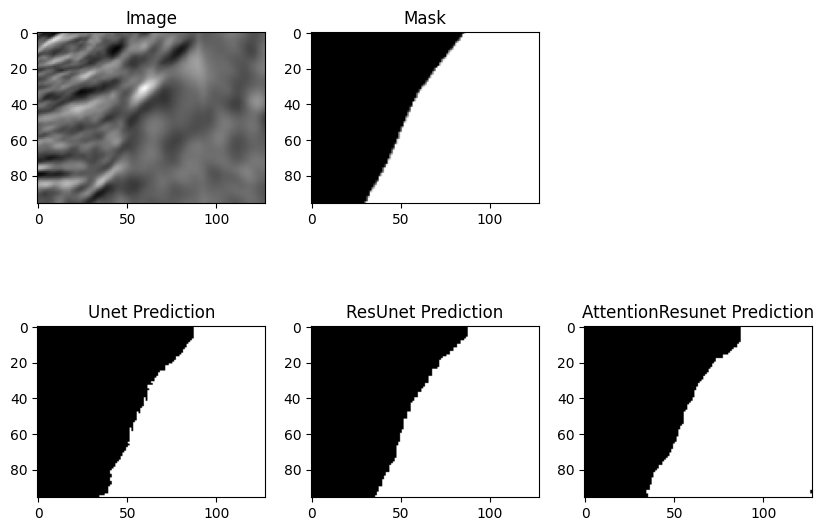

In [33]:
num = random.randint(0, 100)
test_img = x[num]
ground_truth = y[num]
test_img_input=np.expand_dims(test_img, 0)

prediction_unet = (model_unet.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
prediction_resunet = (model_resunet.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
prediction_AttentionResunet = (model_AttentionResunet.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(10,7))
plt.subplot(231)
plt.imshow(test_img)
plt.title('Image')
plt.subplot(232)
plt.imshow(ground_truth,cmap='gray')
plt.title('Mask')
plt.subplot(234)
plt.imshow(prediction_unet,cmap='gray')
plt.title('Unet Prediction')
plt.subplot(235)
plt.imshow(prediction_resunet,cmap='gray')
plt.title('ResUnet Prediction')
plt.subplot(236)
plt.imshow(prediction_AttentionResunet,cmap='gray')
plt.title('AttentionResunet Prediction')

In [34]:
# dice_coeff
I_unet = np.logical_and(ground_truth[:,:,0], prediction_unet)
dice_coeff_unet=(2*np.sum(I_unet))/(np.sum(ground_truth[:,:,0])+np.sum(prediction_unet))

I_resunet = np.logical_and(ground_truth[:,:,0], prediction_resunet)
dice_coeff_resunet=(2*np.sum(I_resunet))/(np.sum(ground_truth[:,:,0])+np.sum(prediction_resunet))

I_attresunet = np.logical_and(ground_truth[:,:,0], prediction_AttentionResunet)
dice_coeff_attresunet=(2*np.sum(I_attresunet))/(np.sum(ground_truth[:,:,0])+np.sum(prediction_AttentionResunet))

print('F1-Score by Unet: %s'% dice_coeff_unet)
print('F1-Score by ResUnet: %s'% dice_coeff_resunet)
print('F1-Score by AttentionResUnet: %s'% dice_coeff_attresunet)

F1-Score by Unet: 0.967496496803163
F1-Score by ResUnet: 0.9775932176299745
F1-Score by AttentionResUnet: 0.9713916559315516
